In [2]:
# %%
import requests
import json
import pandas as pd
from datetime import datetime, timedelta
import time
from pathlib import Path
import csv
import os
print(os.getcwd())
import matplotlib.pyplot as plt
# %%
def apy(apy):
    return (1 + apy)**(1/365) - 1 # Returns a daily nominal interest rate (for use with returns)
# %%
def drpy(drpy): # Returns the daily rewards percentage
    return (drpy/365)
# %%
class CurrencyConfig:
    def __init__(self, Currency_Name, MaximumLTV, Liquidationthreshold, Liquidationpenalty, Ideal_UTIL, BASE, at_ideal, at_Full, Reserve_Factor):
       self.Currency_Name = Currency_Name
       self.MaximumLTV = MaximumLTV
       self.Liquidationthreshold = Liquidationthreshold
       self.Liquidationpenalty = Liquidationpenalty
       self.Ideal_UTIL = Ideal_UTIL
       self.BASE = BASE
       self.at_ideal = at_ideal
       self.at_Full = at_Full
       self.Reserve_Factor = Reserve_Factor
    def UTIL (self, totalVariableDebt, totalLiquidity):
        totalVariableDebt = pd.to_numeric(totalVariableDebt)
        totalLiquidity= pd.to_numeric(totalLiquidity)
        return (totalVariableDebt / totalLiquidity)
    def Variable_Rate (self, totalVariableDebt, totalLiquidity):
        aaa = []
        for i in self.UTIL(totalVariableDebt, totalLiquidity):
            if i < self.Ideal_UTIL:
                aaa.append((i / self.Ideal_UTIL) * self.at_ideal)
            elif i >= self.Ideal_UTIL:
                aaa.append(self.at_ideal + ((i - self.Ideal_UTIL) / (1 - self.Ideal_UTIL)) * self.at_Full)
        return (aaa)
    def Lend_APY (self, totalVariableDebt, totalLiquidity):
        return (self.Variable_Rate(totalVariableDebt, totalLiquidity)) * (1 - self.Reserve_Factor)
    def MAXLend (self):
        return (1/(1-self.MaximumLTV))
    def MAXBorrow (self):
        return (self.MAXLend() * self.MaximumLTV)
currency_dict = {
    'WMATIC' : CurrencyConfig("WMATIC", 0.5, 0.65, 0.1, 0.45, 0, 0.07, 3, 0.2),
    'DAI' : CurrencyConfig("DAI", 0.75, 0.80, 0.05, 0.8, 0, 0.04, 0.75, 0.1),
    'USDC' : CurrencyConfig("USDC", 0.8, 0.85, 0.05, 0.9, 0, 0.04, 0.6, 0.1),
    'USDT' : CurrencyConfig("USDT", 0, 0, 0, 0.9, 0, 0.04, 0.6, 0.1),
    'WETH' : CurrencyConfig("WETH", 0.8, 0.825, 0.05, 0.65, 0, 0.08, 1, 0.1),
    'WBTC' : CurrencyConfig("WBTC", 0.7, 0.75, 0.1, 0.45, 0, 0.07, 1, 0.2),
    'AAVE' : CurrencyConfig("AAVE", 0.5, 0.65, 0.1, 0, 0, 0, 0, 0)
}


# %%
base_url = 'https://aave-api-v2.aave.com/data/liquidity/v2?poolId=' # This is the base API URL
pool_id = '0xd05e3e715d945b59290df0ae8ef85c1bdb684744' # This is the Pool ID for the Matic Network
# %%
# Open the file for w+ (will create it if it doesn't exist)
# Read the last line of the file and check the date
# If it's empty just run from 04-01
# If it's a date but not yesterday, use that as the start date
# If it's yesterday, don't run

# %%
range_of_dates = pd.date_range(start = "2021-04-01",end = (datetime.today() - timedelta(days = 1))).date # List of dates from the start of the AAVE API to yesterday
list_of_dates = []
for date in range_of_dates: # For each date in the list of dates
    list_of_dates.append(date.strftime("%m-%d-%Y")) # Format it correctly for use in the API and append it to a new list
# %%
col_names = ['Date','Symbol','USD', 'Deposit Rate', 'Deposit Rewards', 'Borrow Rate', 'Borrow Rewards', 'availableLiquidity', 'totalVariableDebt'] # These are the fields we want
matic_dataframe = pd.DataFrame(columns = col_names) # Create an empty DataFrame with the column headers
# %%
for date in list_of_dates: # For each date in the list
    print(date) # Show progress as the API is running
    request_url = base_url + pool_id + '&date=' + date # Build the Request URL by combining the base, poolID we want, and one date out of the list of dates
    response_data = requests.get(request_url).json() # Make the request and return the data
    while isinstance(response_data, dict) == True: # If we get an error back
        print(json.dumps(response_data, indent=4)) # Dump the error
        time.sleep(5) # Wait 5 seconds to get around rate limiting
        response_data = requests.get(request_url).json() # Try again
    for response in response_data: # For each element in the response
        if response['symbol'] in ['USDC', 'DAI', 'USDT']: # If the element in the response is a StableCoin
            dict_to_append = { # Set the values of the row we want to append to the DataFrame
                'Date' : date, # Date is the date we queried for
                'Symbol' : response['symbol'], # Set symbol in the row to the symbol the API returns
                'USD' : response['referenceItem']['priceInUsd'], # Set price in the row to the price in Eth the API returns
                'Deposit Rate' : response['liquidityRate'], # Set deposit rate to the deposit rate the API returns
                'Deposit Rewards' : response['aIncentivesAPY'], # Set deposit rewards to the rate the API returns
                'Borrow Rate' : response['variableBorrowRate'],
                'Borrow Rewards' : response['vIncentivesAPY'],
                'availableLiquidity' : response['availableLiquidity'],
                'totalVariableDebt' : response['totalVariableDebt']
            }
            matic_dataframe = matic_dataframe.append(dict_to_append, ignore_index = True) # Append the row to the DataFrame
            # Write the line to the file
            # Move the stuff around it checks the file every time it goes to call the API (combine the cells)
# Close the file
# %%
#--------Once you've imported the data, only ever run from this cell downwards---------
editing_dataframe = matic_dataframe.copy() # Create a copy of the dataframe
editing_dataframe.head()
file_path = Path("api_data.csv")
editing_dataframe.to_csv(file_path)
# %%
editing_dataframe['Borrow Rate'] = editing_dataframe['Borrow Rate'].astype(float) # Set data type to float
editing_dataframe['Deposit Rate'] = editing_dataframe['Deposit Rate'].astype(float) # Set data type to float
editing_dataframe['Borrow Rewards'] = editing_dataframe['Borrow Rewards'].astype(float) # Set data type to float
editing_dataframe['Deposit Rewards'] = editing_dataframe['Deposit Rewards'].astype(float) # Set data type to float
# editing_dataframe.tail() # Use editing_dataframe as your reference dataframe moving forward until the CSV writing gets completed.

col_names = ['Date', 'Borrow Token', 'Deposit Token', 'Return Difference', 'Lend Size', 'Borrow Size', 'Rewards Gained', 'Initial Investment'] # These are the fields we want
stupid_dataframe = pd.DataFrame(columns = col_names)
stupid_dataframe['Date'] = stupid_dataframe['Date'].astype(str)
stupid_dataframe['Borrow Token'] = stupid_dataframe['Borrow Token'].astype(str)
stupid_dataframe['Deposit Token'] = stupid_dataframe['Deposit Token'].astype(str)
stupid_dataframe['Lend Size'] = stupid_dataframe['Lend Size'].astype(float)
stupid_dataframe['Borrow Size'] = stupid_dataframe['Borrow Size'].astype(float)
# %%
initial_investment = 10000
for date in list_of_dates:
    min_borrow = editing_dataframe.loc[editing_dataframe['Date'] == date]['Borrow Rate'].min()
    max_deposit = editing_dataframe.loc[(editing_dataframe['Date'] == date)]['Deposit Rate'].max()
    max_deposit_non_USDT = editing_dataframe.loc[(editing_dataframe['Date'] == date) & (editing_dataframe['Symbol'] != 'USDT')]['Deposit Rate'].max()
    min_borrow_row = editing_dataframe.loc[(editing_dataframe['Date'] == date) & (editing_dataframe['Borrow Rate'] == min_borrow)]
    max_deposit_row = editing_dataframe.loc[(editing_dataframe['Date'] == date) & (editing_dataframe['Deposit Rate'] ==  max_deposit)]
    max_deposit_row_non_USDT = editing_dataframe.loc[(editing_dataframe['Date'] == date) & (editing_dataframe['Deposit Rate'] ==  max_deposit_non_USDT)]
    if (min_borrow < max_deposit_non_USDT):
        max_lend_leverage = currency_dict[max_deposit_row_non_USDT['Symbol'].values[0]].MAXLend()
        min_borrow_leverage = currency_dict[max_deposit_row_non_USDT['Symbol'].values[0]].MAXBorrow()
        initial_investment = (initial_investment*(1+apy(max_deposit_non_USDT*(max_lend_leverage) - min_borrow*(min_borrow_leverage))+drpy(min_borrow_row['Borrow Rewards'].values[0]*(min_borrow_leverage) + max_deposit_row_non_USDT['Deposit Rewards'].values[0]*(max_lend_leverage))))
        dict_to_append = { # Set the values of the row we want to append to the DataFrame
                'Date' : date,
                'Borrow Token' : min_borrow_row['Symbol'].values[0],
                'Deposit Token' : max_deposit_row_non_USDT['Symbol'].values[0],
                'Return Difference' : apy(max_deposit_non_USDT*(max_lend_leverage) - min_borrow*(min_borrow_leverage)),
                'Lend Size' : max_lend_leverage,
                'Borrow Size' : min_borrow_leverage,
                'Rewards Gained' : drpy(min_borrow_row['Borrow Rewards'].values[0]*(min_borrow_leverage) + max_deposit_row_non_USDT['Deposit Rewards'].values[0]*(max_lend_leverage)),
                'Initial Investment' : initial_investment
            }
    else:
        dict_to_append = { # Set the values of the row we want to append to the DataFrame
                'Date' : date,
                'Borrow Token' : "N/A",
                'Deposit Token' : max_deposit_row['Symbol'].values[0],
                'Return Difference' : apy(max_deposit),
                'Lend Size' : 0,
                'Borrow Size' : 0,
                'Rewards Gained': drpy(max_deposit_row['Deposit Rewards'].values[0]),
                'Initial Investment' : initial_investment
        }
    stupid_dataframe = stupid_dataframe.append(dict_to_append, ignore_index = True)
stupid_dataframe.head(100)
# %%
#editing_dataframe.loc[editing_dataframe['Date'] == "04-05-2021"]
# %%
returns_dataframe = matic_dataframe.copy()
returns_dataframe['USD'] = pd.to_numeric(returns_dataframe['USD'])
returns_dataframe['Deposit Rate'] = pd.to_numeric(returns_dataframe['Deposit Rate'])
returns_dataframe['Deposit Rewards'] = pd.to_numeric(returns_dataframe['Deposit Rewards'])
returns_dataframe['Borrow Rate'] = pd.to_numeric(returns_dataframe['Borrow Rate'])
returns_dataframe.head()

# %%
col_names = ['Symbol','Aggregate Rewards']
rewards_dataframe = pd.DataFrame(columns = col_names)
for symbol in editing_dataframe['Symbol'].unique():
    dict_to_append = {
        'Symbol': symbol,
        'Aggregate Rewards': drpy(editing_dataframe.loc[editing_dataframe['Symbol'] == symbol,'Deposit Rewards'].astype(float)).sum()
    }
    rewards_dataframe = rewards_dataframe.append(dict_to_append, ignore_index = True)
dict_to_append = {
        'Symbol': 'ALGO',
        'Aggregate Rewards': stupid_dataframe['Rewards Gained'].sum()
    }
rewards_dataframe = rewards_dataframe.append(dict_to_append, ignore_index = True)
rewards_dataframe.head()
# %%
# TO DO: PLOTS AND PRESENTATION

C:\Users\Yonathan\Desktop\FinTech\Project(s)-sandbox
04-01-2021
04-02-2021
04-03-2021
04-04-2021
04-05-2021
04-06-2021
04-07-2021
04-08-2021
04-09-2021
04-10-2021
04-11-2021
04-12-2021
04-13-2021
04-14-2021
04-15-2021
04-16-2021
04-17-2021
04-18-2021
04-19-2021
04-20-2021
04-21-2021
04-22-2021
04-23-2021
04-24-2021
04-25-2021
04-26-2021
04-27-2021
04-28-2021
04-29-2021
04-30-2021
05-01-2021
05-02-2021
05-03-2021
05-04-2021
05-05-2021
05-06-2021
05-07-2021
05-08-2021
05-09-2021
05-10-2021
05-11-2021
05-12-2021
05-13-2021
05-14-2021
05-15-2021
05-16-2021
05-17-2021
05-18-2021
05-19-2021
05-20-2021
05-21-2021
05-22-2021
05-23-2021
05-24-2021
05-25-2021
05-26-2021
05-27-2021
05-28-2021
05-29-2021
05-30-2021
05-31-2021
06-01-2021
06-02-2021
06-03-2021
06-04-2021
06-05-2021
06-06-2021


,Symbol,Aggregate Rewards
0,USDC,0.005660
1,DAI,0.009524
2,USDT,0.022433
3,ALGO,0.058321


In [3]:
DAI_RE = rewards_dataframe.loc[rewards_dataframe['Symbol']=='DAI']
USDT_RE = rewards_dataframe.loc[rewards_dataframe['Symbol']=='USDT']
USDC_RE = rewards_dataframe.loc[rewards_dataframe['Symbol']=='USDC']



<AxesSubplot:title={'center':'Aggregate Rewards Over Time'}, xlabel='Symbol'>

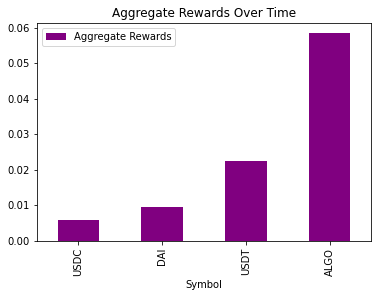

In [4]:
rewards_dataframe.plot.bar(x="Symbol", y ='Aggregate Rewards', color = 'purple', title ='Aggregate Rewards Over Time')

In [5]:
DAI_OT = returns_dataframe.loc[returns_dataframe['Symbol']=='DAI']
USDT_OT = returns_dataframe.loc[returns_dataframe['Symbol']=='USDT']
USDC_OT = returns_dataframe.loc[returns_dataframe['Symbol']=='USDC']

In [6]:
DAI_RET = returns_dataframe.loc[returns_dataframe['Symbol']=='DAI']
USDT_RET = returns_dataframe.loc[returns_dataframe['Symbol']=='USDT']
USDC_RET= returns_dataframe.loc[returns_dataframe['Symbol']=='USDC']

<AxesSubplot:title={'center':'Lending Rate for each Stable coin'}, xlabel='Date'>

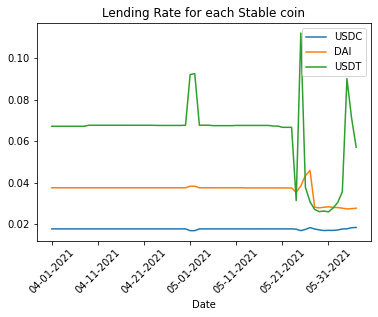

In [8]:
PLT1 = USDC_RET.plot.line(x='Date', y='Deposit Rate', rot=90, label = 'USDC', )
DAI_RET.plot.line(x='Date', y='Deposit Rate', rot=90, ax=PLT1, label = 'DAI')
USDT_RET.plot.line(x='Date', y='Deposit Rate', rot=45, ax = PLT1, label = 'USDT', title = "Lending Rate for each Stable coin")
# Needs to be graphed: Borrow Rate, Borrow Rewards, and Lending Rewards

In [31]:
col_names = ['Symbol','Aggregate Returns']
returns_dataframe = pd.DataFrame(columns = col_names)
for symbol in editing_dataframe['Symbol'].unique():
    first_returns=(drpy(editing_dataframe.loc[editing_dataframe['Symbol'] == symbol,'Deposit Rate'].astype(float)).sum() + drpy(editing_dataframe.loc[editing_dataframe['Symbol'] == symbol,'Deposit Rewards'].astype(float)).sum())
    dict_to_append = {
        'Symbol': symbol,
        'Aggregate Returns': drpy(editing_dataframe.loc[editing_dataframe['Symbol'] == symbol,'Deposit Rate'].astype(float)).sum(),
        'Total Returns': first_returns
    }
    returns_dataframe = returns_dataframe.append(dict_to_append, ignore_index = True)
Second_returns = stupid_dataframe['Return Difference'].sum() + stupid_dataframe['Rewards Gained'].sum()  
dict_to_append = {
        'Symbol': 'ALGO',
        'Aggregate Returns': stupid_dataframe['Return Difference'].sum(),
        'Total Returns': Second_returns
}
returns_dataframe = returns_dataframe.append(dict_to_append, ignore_index = True)
returns_dataframe.head()
# %%


,Symbol,Aggregate Returns,Total Returns
0,USDC,0.003159,0.008712
1,DAI,0.006521,0.015869
2,USDT,0.011303,0.033331
3,ALGO,0.010245,0.068161


<AxesSubplot:title={'center':'Total Returns Over Time'}, xlabel='Symbol'>

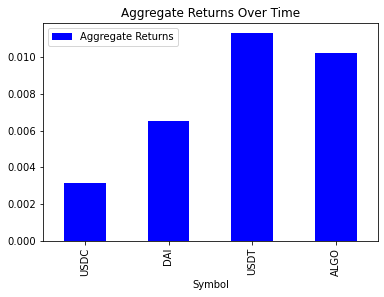

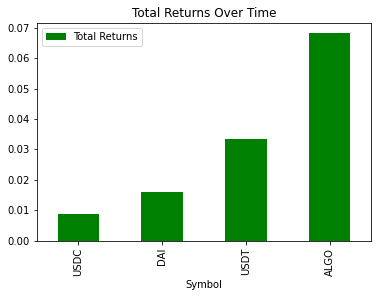

In [32]:
returns_dataframe.plot.bar(x="Symbol", y ='Aggregate Returns', color = 'Blue', title ='Aggregate Returns Over Time')
returns_dataframe.plot.bar(x="Symbol", y ='Total Returns', color = 'green', title ='Total Returns Over Time')